# **Introduction**

In this section, two machine learning models will be used to classify the `vivo_ano3` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 1 if the patient is alive after three years of treatment and 0 if not.

The first approach is using the "raw data", the second is without the `EC` column and the third is using the grouped years.

# **First approach**

Approach with "raw data".

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 92)
(32891, 92)


In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

delta_t4      431715
delta_t6      431715
delta_t5      431715
DTRECIDIVA    431715
HORMONIO           0
QUIMIO             0
dtype: int64

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

delta_t4      29244
delta_t6      29244
delta_t5      29244
DTRECIDIVA    29244
HORMONIO          0
QUIMIO            0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.746404
delta_t7        0.740191
delta_t9        0.737903
vivo_ano5       0.688613
vivo_ano1       0.550659
delta_t5        0.519957
delta_t4        0.511500
delta_t6        0.507883
ob              0.365068
ob_sem_rec      0.360261
vivo_sem_rec    0.319610
HORMONIO        0.236603
CIRURGIA        0.215579
MORFO           0.208184
ANODIAG         0.201279
ULTINFO         0.189965
vivo_com_rec    0.124450
QUIMIO          0.116880
G               0.103949
Name: vivo_ano3, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.759271
delta_t7        0.753968
delta_t9        0.749534
vivo_ano5       0.667262
vivo_ano1       0.547481
delta_t5        0.512524
delta_t4        0.510673
delta_t6        0.504915
ob_sem_rec      0.389451
ob              0.385518
vivo_sem_rec    0.341957
ANODIAG         0.258962
CIRURGIA        0.235109
ULTINFO         0.218422
HORMONIO        0.215508
MORFO           0.186335
CATEATEND       0.139831
QUIMIO          0.120061
delta_t3        0.116820
Name: vivo_ano3, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.vivo_ano3.value_counts()

0    260942
1    245095
Name: vivo_ano3, dtype: int64

In [ ]:
df_fora.vivo_ano3.value_counts()

0    17264
1    15627
Name: vivo_ano3, dtype: int64

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.ob == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 92)

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.ob == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 92)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`.The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`. 

The information related to recurrence will be removed from the features, `RECNENHUM`, `RECLOCAL`, `RECREGIO`, `RECDIST`, `REC01`, `REC02`, `REC03`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob',
             'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec',
             'vivo_sem_rec', 'ULTINFO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, random_state=seed)

X_train = (367642, 66), X_test = (102296, 66)
y_train = (367642,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, random_state=seed)

X_train = (23516, 66), X_test = (6320, 66)
y_train = (23516,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:4_000_000, 1:1})
rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4000000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:4_500_000, 1:1}) 
rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4500000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A lower weight was also used for the class with values 1, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.6,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.35,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Results**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

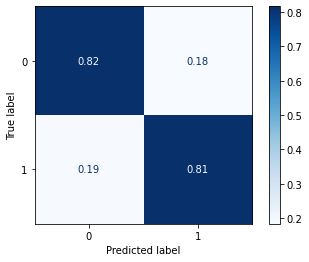

In [ ]:
plot_confusion_matrix(rf_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 81% of accuracy.

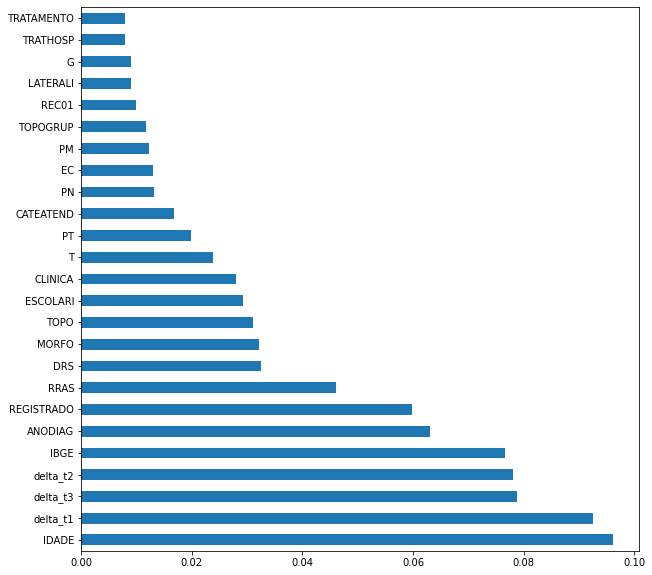

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`. The last three being the difference, in days, between diagnosis and consultation, treatment and consultation and treatment and diagnosis, respectively.

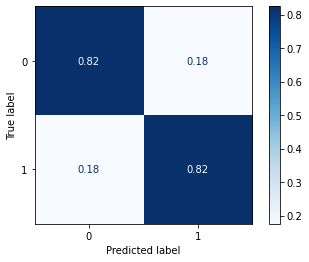

In [ ]:
plot_confusion_matrix(rf_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 82% of accuracy.


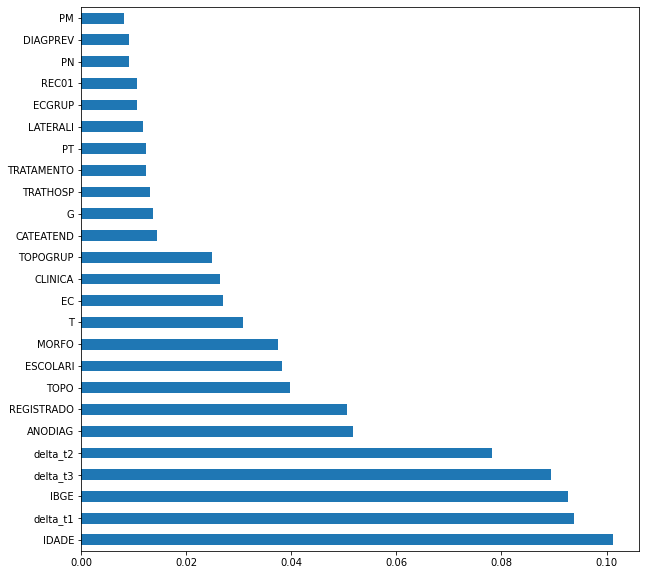

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`. `delta_t1` is the difference between diagnosis and consultation, and `delta_t3` is the deffence between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

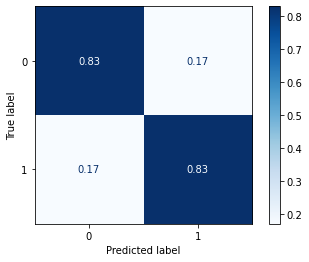

In [ ]:
plot_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, similar to the Random Forest model. The accuracy was 83%.

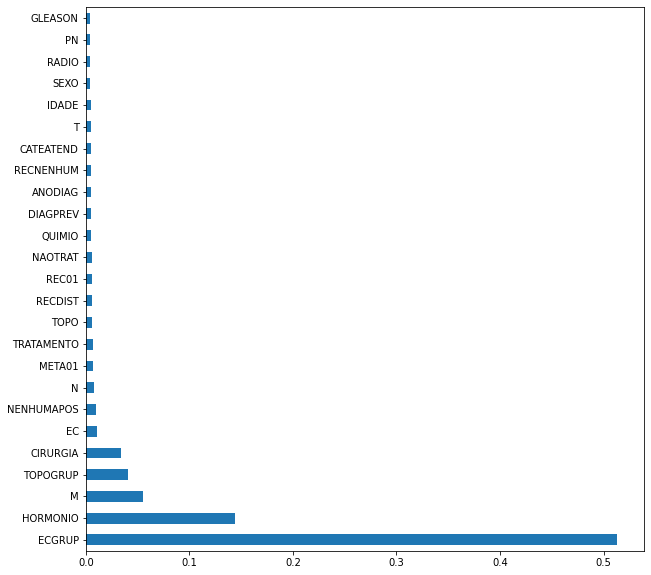

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, with a lot advantage, `HORMONIO`, `M` and `TOPOGRUP`.

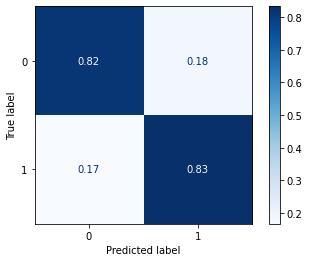

In [ ]:
plot_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, with 82% of accuracy. 

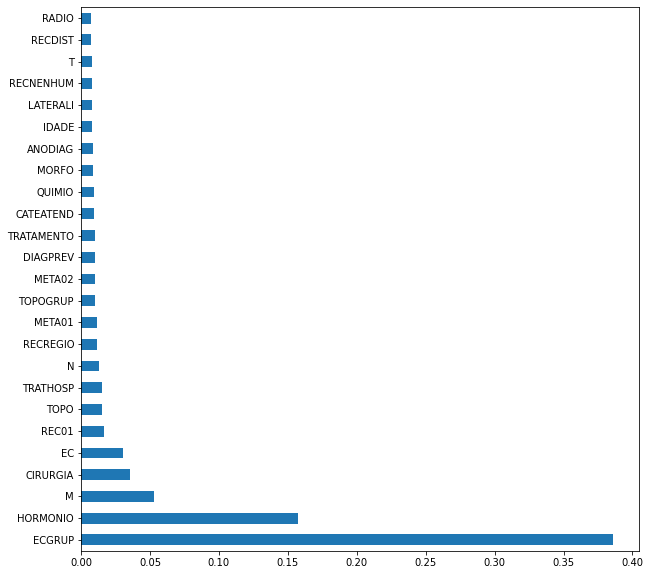

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, with a good advantage, `HORMONIO`, `M` and `CIRURGIA`.

# **Second approach**

Approach without column `EC` as a feature.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 92)
(32891, 92)


In [ ]:
df_SP.isna().sum().sort_values(ascending=False).head(6)

delta_t4      431715
delta_t6      431715
delta_t5      431715
DTRECIDIVA    431715
HORMONIO           0
QUIMIO             0
dtype: int64

In [ ]:
df_fora.isna().sum().sort_values(ascending=False).head(6)

delta_t4      29244
delta_t6      29244
delta_t5      29244
DTRECIDIVA    29244
HORMONIO          0
QUIMIO            0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.746404
delta_t7        0.740191
delta_t9        0.737903
vivo_ano5       0.688613
vivo_ano1       0.550659
delta_t5        0.519957
delta_t4        0.511500
delta_t6        0.507883
ob              0.365068
ob_sem_rec      0.360261
vivo_sem_rec    0.319610
HORMONIO        0.236603
CIRURGIA        0.215579
MORFO           0.208184
ANODIAG         0.201279
ULTINFO         0.189965
vivo_com_rec    0.124450
QUIMIO          0.116880
G               0.103949
Name: vivo_ano3, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.759271
delta_t7        0.753968
delta_t9        0.749534
vivo_ano5       0.667262
vivo_ano1       0.547481
delta_t5        0.512524
delta_t4        0.510673
delta_t6        0.504915
ob_sem_rec      0.389451
ob              0.385518
vivo_sem_rec    0.341957
ANODIAG         0.258962
CIRURGIA        0.235109
ULTINFO         0.218422
HORMONIO        0.215508
MORFO           0.186335
CATEATEND       0.139831
QUIMIO          0.120061
delta_t3        0.116820
Name: vivo_ano3, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.vivo_ano3.value_counts()

0    260942
1    245095
Name: vivo_ano3, dtype: int64

In [ ]:
df_fora.vivo_ano3.value_counts()

0    17264
1    15627
Name: vivo_ano3, dtype: int64

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.ob == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 92)

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.ob == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 92)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`.The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob',
             'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec',
             'vivo_sem_rec', 'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano3, list_drop, lb, random_state=seed)

X_train = (367642, 65), X_test = (102296, 65)
y_train = (367642,), y_test = (102296,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano3, list_drop, lb, random_state=seed)

X_train = (23516, 65), X_test = (6320, 65)
y_train = (23516,), y_test = (6320,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the `random_state` and `class_weight` hyperparameters will be used, the first one to obtain the same training values of the model every time it is runned. The `class_weight` was used because even after balancing the data the model still has difficulty to learn the class with fewer examples.



In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:4_000_000, 1:1})
rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4000000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:4_500_000, 1:1}) 
rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4500000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A lower weight was also used for the class with values 1, using the hyperparameter `scale_pos_weight`, for both models.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=15,
                               scale_pos_weight=0.6,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Other states
xgboost_fora = xgb.XGBClassifier(max_depth=15,
                                 scale_pos_weight=0.35,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

## **Results**

After training the models, we will use the confusion matrix to verify the performances, the features importances for each model will also be obtained.

### **Random Forest**


Below we have the confusion matrices for the Random Forest models, followed by the graph with the most important features for each model.

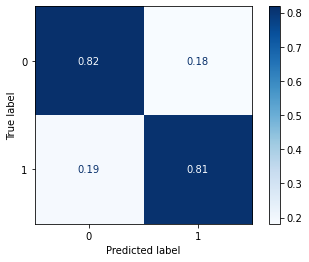

In [ ]:
plot_confusion_matrix(rf_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest algorithm with the SP data shows a good performance of the model, because we obtained a balanced main diagonal, with 81% of accuracy.

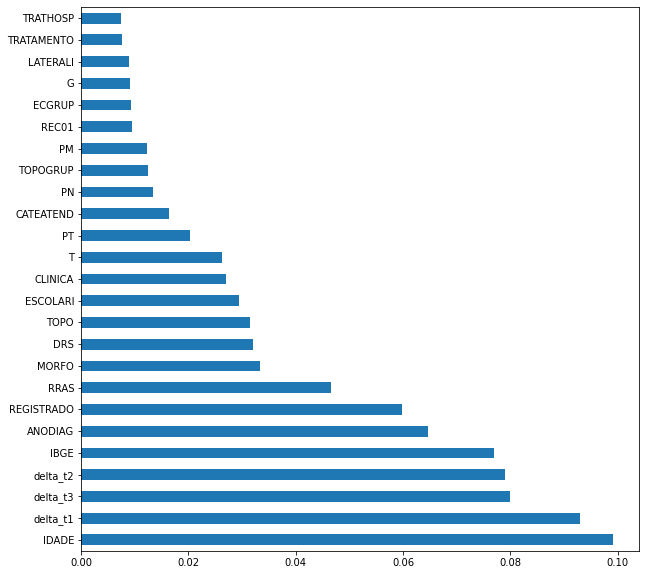

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`. The last three being the difference, in days, between diagnosis and consultation, treatment and consultation and treatment and diagnosis, respectively.

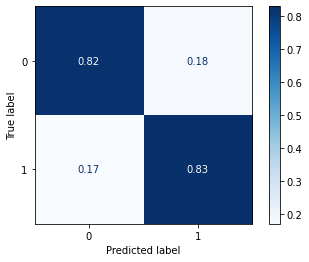

In [ ]:
plot_confusion_matrix(rf_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 82% of accuracy.


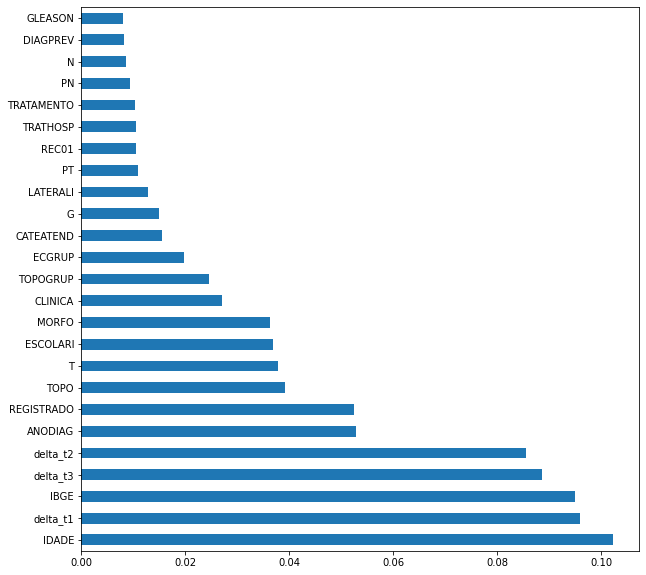

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t3`. `delta_t1` is the difference between diagnosis and consultation, and `delta_t3` is the deffence between treatment and consultation.

### **XGBoost**


Below we have the confusion matrices for the XGBoost models, followed by the graph with the most important features for each model.

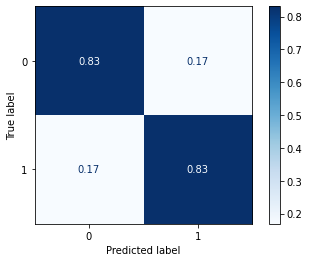

In [ ]:
plot_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost algorithm with the SP data shows a good performance of the model, similar to the Random Forest model. The accuracy was 83%.

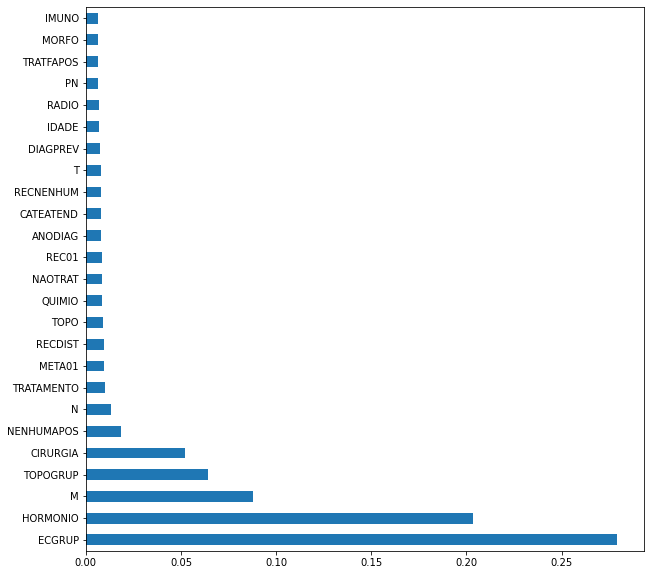

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, with some advantage, `HORMONIO`, `M` and `TOPOGRUP`.

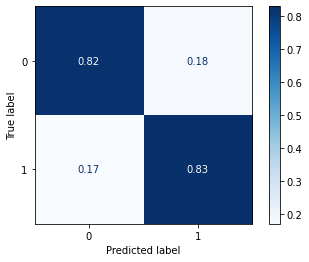

In [ ]:
plot_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS, cmap='Blues', 
                      normalize='true', values_format='.2f')
plt.show() 

> The confusion matrix obtained for the XGBoost algorithm with the data from another states also shows a good performance of the model, with 82% of accuracy. 

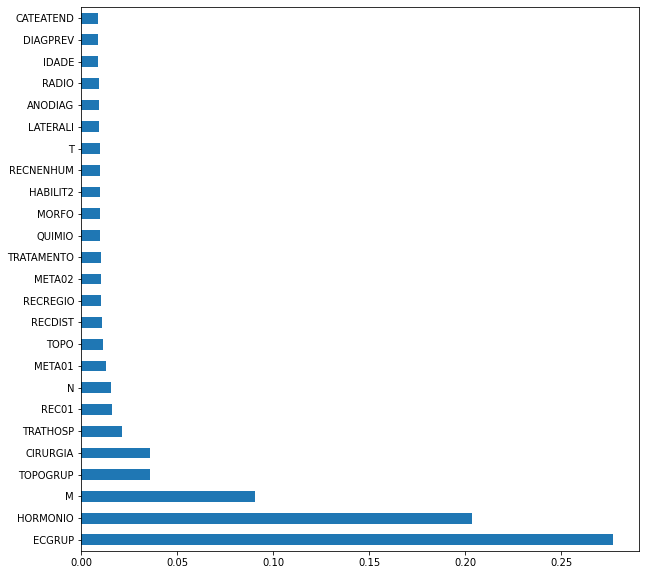

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, with some advantage, `HORMONIO`, `M` and `CIRURGIA`.

# **Third approach**

Approach with grouped years and without the column `EC`.

## **Reading the data**

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 92)
(32891, 92)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

delta_t4      431715
delta_t6      431715
delta_t5      431715
DTRECIDIVA    431715
HORMONIO           0
QUIMIO             0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

delta_t4      29244
delta_t6      29244
delta_t5      29244
DTRECIDIVA    29244
HORMONIO          0
QUIMIO            0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.746404
delta_t7        0.740191
delta_t9        0.737903
vivo_ano5       0.688613
vivo_ano1       0.550659
delta_t5        0.519957
delta_t4        0.511500
delta_t6        0.507883
ob              0.365068
ob_sem_rec      0.360261
vivo_sem_rec    0.319610
HORMONIO        0.236603
CIRURGIA        0.215579
MORFO           0.208184
ANODIAG         0.201279
ULTINFO         0.189965
vivo_com_rec    0.124450
QUIMIO          0.116880
G               0.103949
Name: vivo_ano3, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano3']).sort_values(ascending = False).head(20)

vivo_ano3       1.000000
delta_t8        0.759271
delta_t7        0.753968
delta_t9        0.749534
vivo_ano5       0.667262
vivo_ano1       0.547481
delta_t5        0.512524
delta_t4        0.510673
delta_t6        0.504915
ob_sem_rec      0.389451
ob              0.385518
vivo_sem_rec    0.341957
ANODIAG         0.258962
CIRURGIA        0.235109
ULTINFO         0.218422
HORMONIO        0.215508
MORFO           0.186335
CATEATEND       0.139831
QUIMIO          0.120061
delta_t3        0.116820
Name: vivo_ano3, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance. We will need to fix this problem in the preprocessing step and in the models training.

In [ ]:
df_SP.vivo_ano3.value_counts()

0    260942
1    245095
Name: vivo_ano3, dtype: int64

In [ ]:
df_fora.vivo_ano3.value_counts()

0    17264
1    15627
Name: vivo_ano3, dtype: int64

Years of diagnosis present in the data.

In [ ]:
np.sort(df_SP.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [ ]:
np.sort(df_fora.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

## **Preprocessing**

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least three years.

**SP**

In [ ]:
df_SP_ano3 = df_SP[~((df_SP.ob == 0) & (df_SP.vivo_ano3 == 0))]
df_SP_ano3.shape

(409182, 92)

**Other states**

In [ ]:
df_fora_ano3 = df_fora[~((df_fora.ob == 0) & (df_fora.vivo_ano3 == 0))]
df_fora_ano3.shape

(25280, 92)

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. For the features we will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. The date columns will also be removed, `DTCONSULT`, `DTDIAG`, `DTTRAT`, `DTRECIDIVA`, `DTULTINFO` and `DTPREENCH`, because we already have the difference in days in other columns. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. The columns `CONSDIAG`, `TRATCONS`, `DIAGTRAT` contain the same information as the `delta_t1`, `delta_t2`, `delta_t3`.

Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTRECIDIVA', 'DTULTINFO',
             'DTPREENCH', 'FAIXAETAR', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'delta_t4', 
             'delta_t5', 'delta_t6', 'delta_t7', 'delta_t8', 'delta_t9', 'ob',
             'vivo_ano1', 'vivo_ano5', 'ob_com_rec', 'ob_sem_rec', 'vivo_com_rec',
             'vivo_sem_rec', 'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano3'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, last_year=2003, 
                                                                                                random_state=seed)

X_train = (53228, 65), X_test = (15329, 65)
y_train = (53228,), y_test = (15329,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, last_year=2007, 
                                                                                                random_state=seed)

X_train = (70060, 65), X_test = (19267, 65)
y_train = (70060,), y_test = (19267,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, last_year=2011, 
                                                                                                random_state=seed)

X_train = (97274, 65), X_test = (25886, 65)
y_train = (97274,), y_test = (25886,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, last_year=2015, 
                                                                                                random_state=seed)

X_train = (115836, 65), X_test = (29854, 65)
y_train = (115836,), y_test = (29854,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, last_year=2021, 
                                                                                                random_state=seed)

X_train = (40680, 65), X_test = (11961, 65)
y_train = (40680,), y_test = (11961,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, last_year=2003, 
                                                                                                random_state=seed)

X_train = (3108, 65), X_test = (877, 65)
y_train = (3108,), y_test = (877,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, last_year=2007, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (4648, 65), X_test = (1218, 65)
y_train = (4648,), y_test = (1218,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, last_year=2011, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (5732, 65), X_test = (1463, 65)
y_train = (5732,), y_test = (1463,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, last_year=2015, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (7310, 65), X_test = (1782, 65)
y_train = (7310,), y_test = (1782,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora_ano3, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, last_year=2020, 
                                                                                                random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



X_train = (3186, 65), X_test = (981, 65)
y_train = (3186,), y_test = (981,)


## **Training and validation of the models**

After dividing the data into training and testing, using the encoder, normalizing and balancing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because even after balancing the data the models still have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:3_500_000, 1:1})
rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3500000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

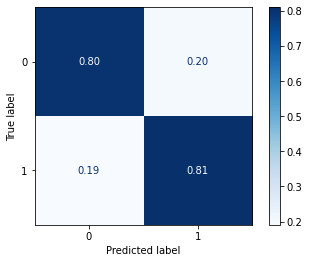

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2000 to 2003, shows a good performance, with 80% of accuracy.

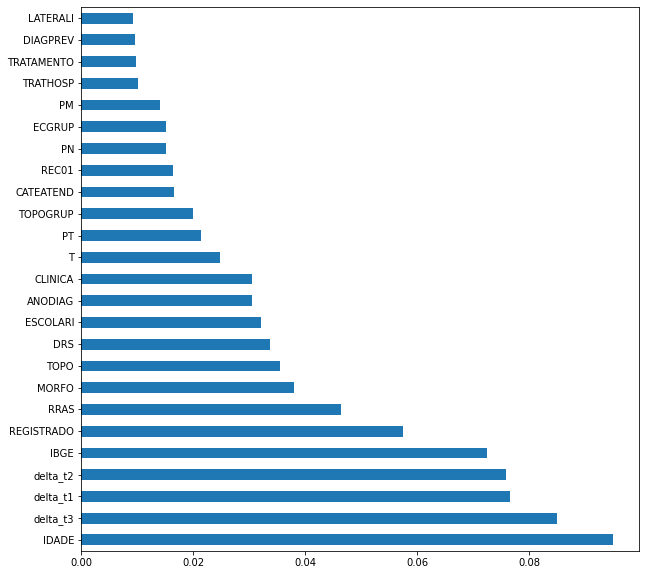

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `IDADE`, `delta_t3`, `delta_t1` and `delta_t2`.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:3_800_000, 1:1})
rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3800000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

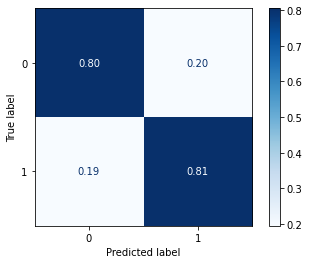

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2004 to 2007, shows a good performance of the model, with 80% of accuracy.

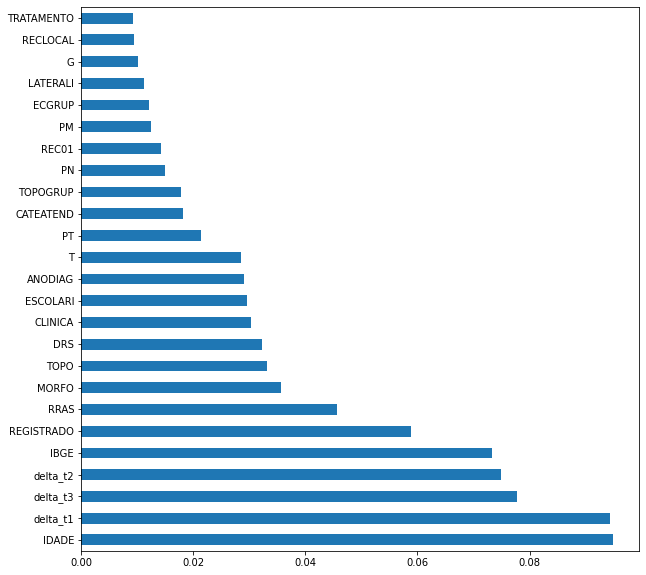

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t3` and `delta_t2`.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:4_000_000, 1:1})
rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4000000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

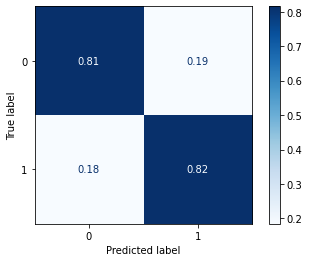

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuray.

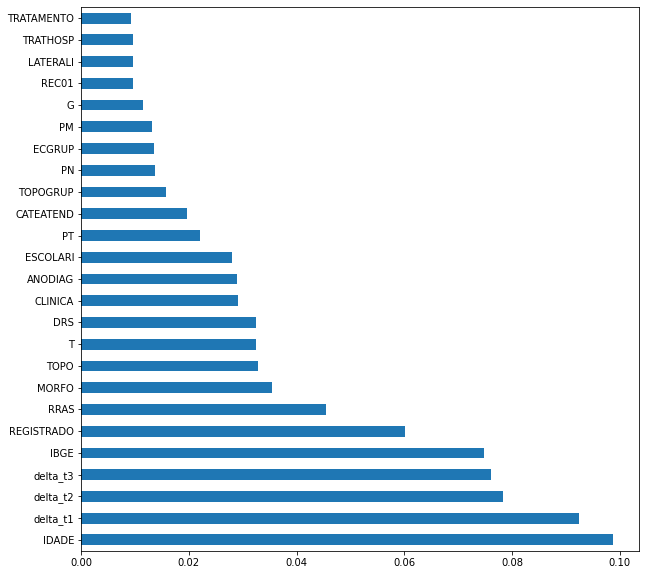

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t2` and `delta_t3`.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:4_500_000, 1:1})
rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4500000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

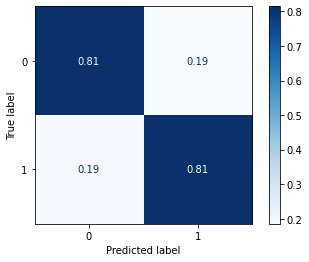

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2012 to 2015, shows a good performance of the model, with 81% of accuracy.

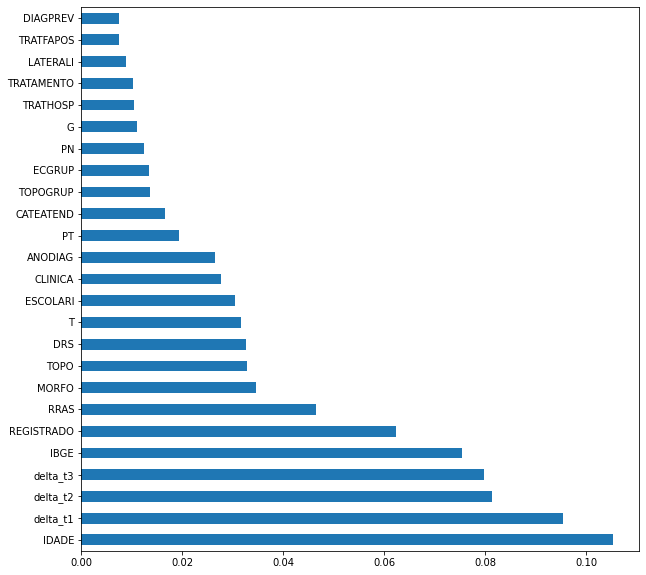

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t2` and `delta_t3`.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1_700_000, 1:1})
rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1700000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

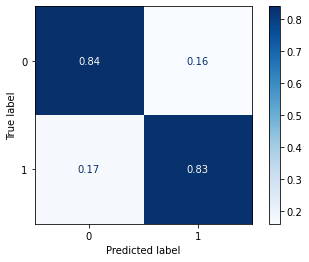

In [ ]:
plot_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the SP data from 2016 to 2021, shows a good performance of the model. The accuracy was 83%.

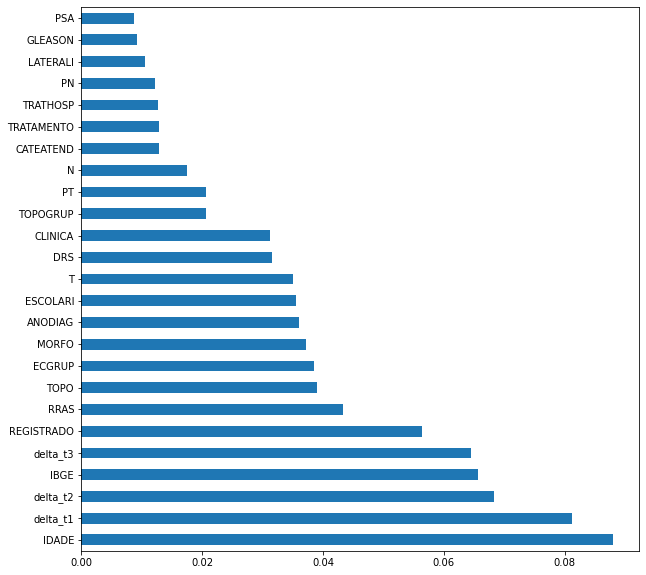

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `IDADE`, `delta_t1`, `delta_t2` and `IBGE`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:6_500_000, 1:1})
rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 6500000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

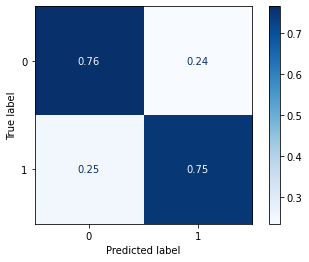

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with the other states data from 2000 to 2003, shows a good performance of the model, and we have a balanced main diagonal in the confusion matrix. The accuracy was 75%.

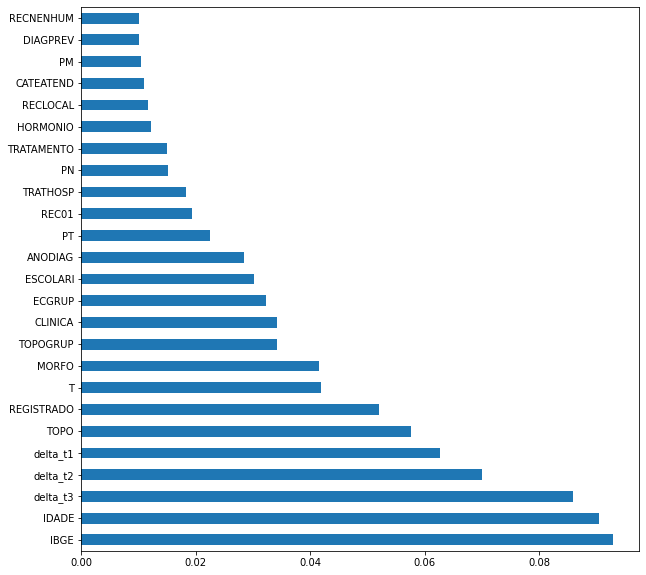

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `IBGE`, `IDADE`, `delta_t3` and `delta_t2`.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:4_500_000, 1:1})
rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4500000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

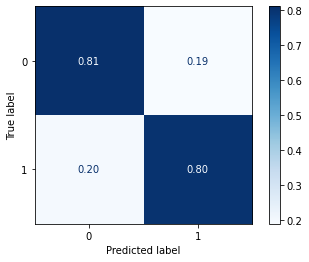

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07, 
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


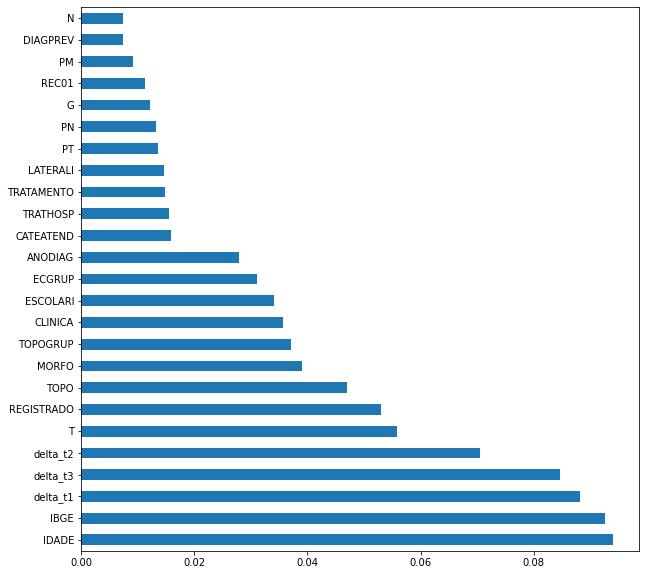

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `IDADE`, `IBGE`, `delta_t1` and `delta_t3`.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:4_700_000, 1:1})
rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 4700000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

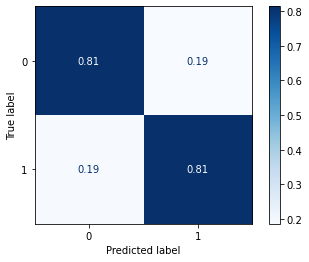

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a very good performance of the model, with 81% of accuracy.


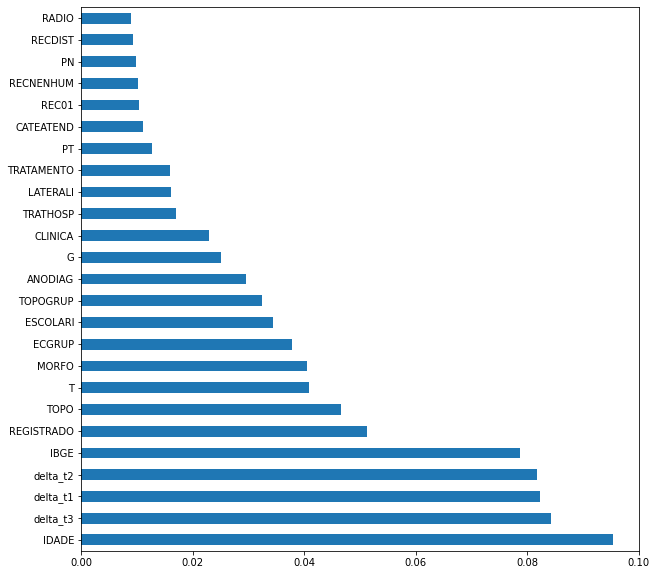

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `IDADE`, `delta_t3`, `delta_t1` and `delta_t2`.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:5_000_000, 1:1})
rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 5000000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

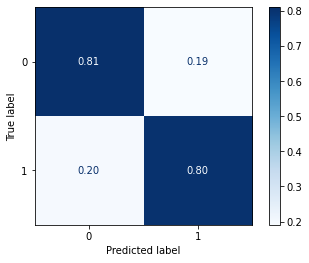

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, we have a balanced main diagonal in the confusion matrix, with 80% of accuracy.


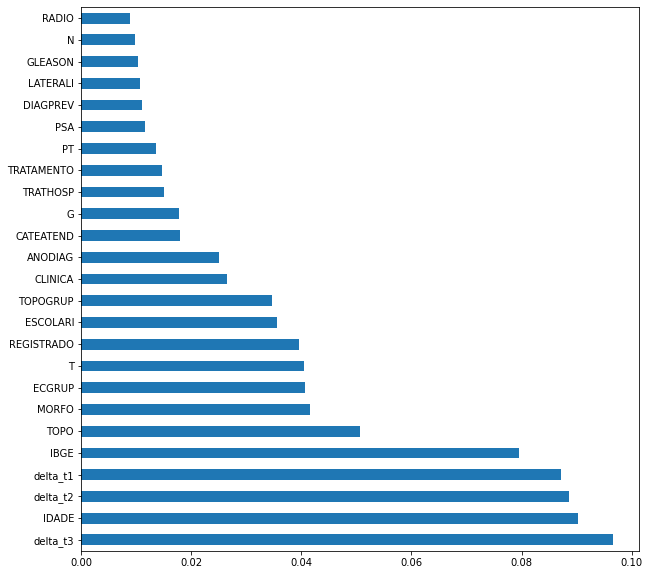

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `delta_t3`, `IDADE`, `delta_t2` and `delta_t1`.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:3_000_000, 1:1})
rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3000000, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=10, verbose=0, warm_start=False)

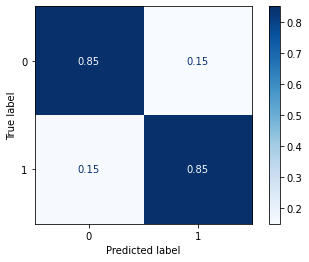

In [ ]:
plot_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance, the accuracy was 85%.




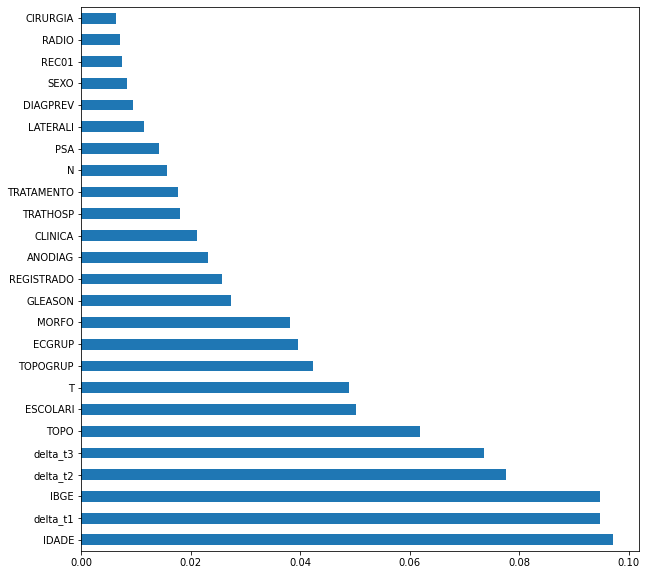

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `IDADE`, `delta_t1`, `IBGE` and `delta_t2`.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 15 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.55)
xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.55, seed=None,
              silent=None, subsample=1, verbosity=1)

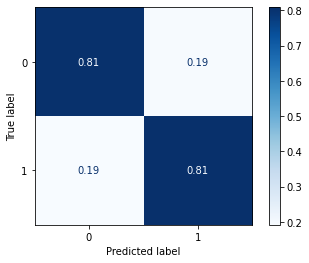

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2000 to 2003, shows a very good performance of the model, as well as the Random Forest model, here with 81% of accuracy.

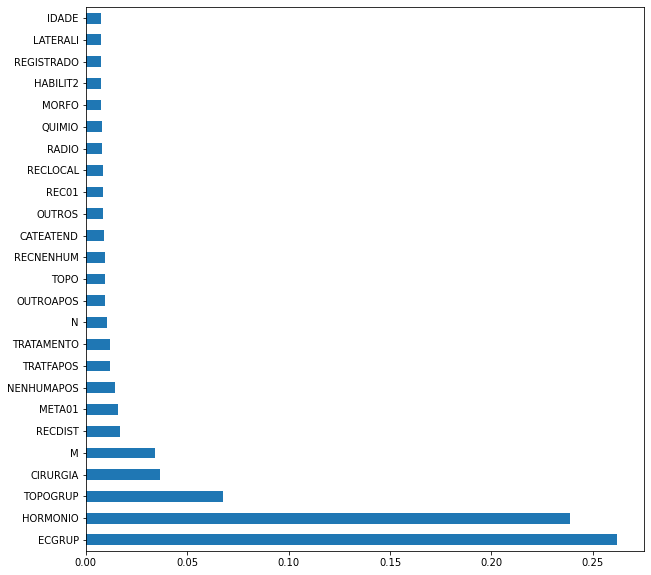

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `TOPOGRUP` and `CIRURGIA`.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=0.55)
xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.55, seed=None,
              silent=None, subsample=1, verbosity=1)

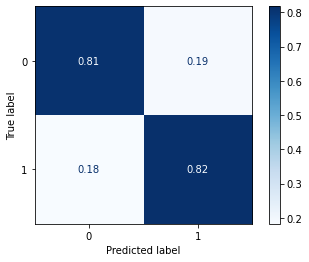

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.

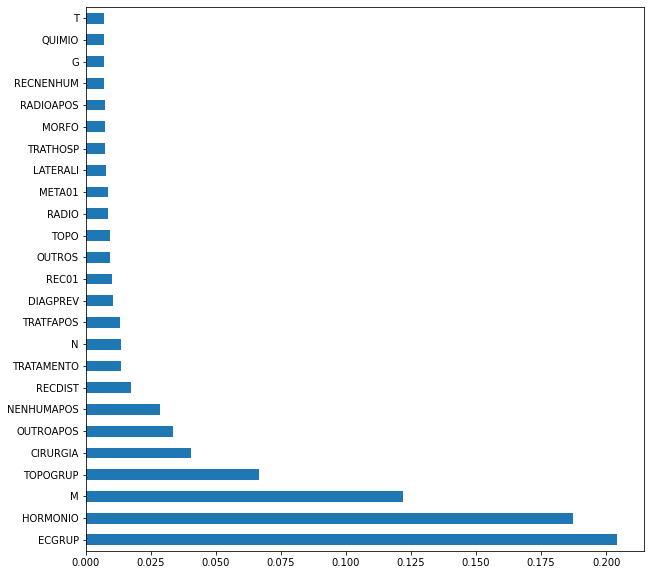

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `TOPOGRUP`.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=0.4)
xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.4, seed=None,
              silent=None, subsample=1, verbosity=1)

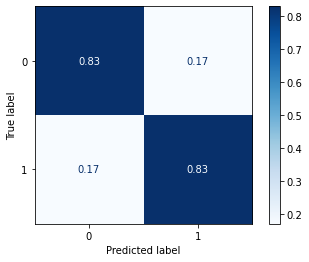

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

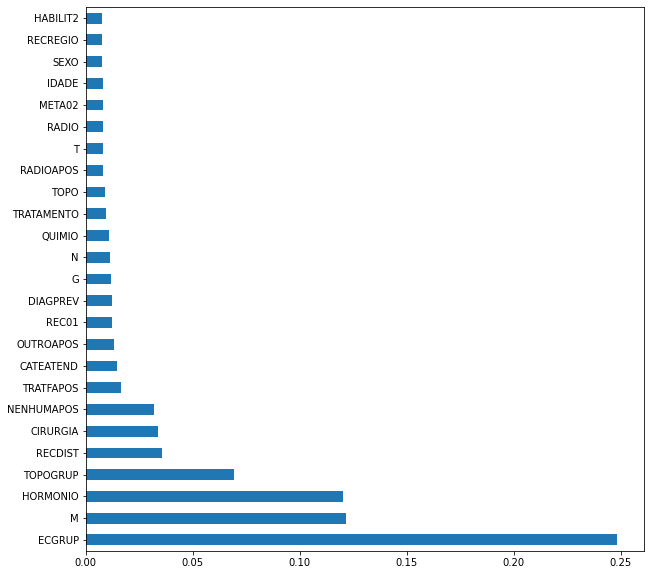

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, with a good advantage, `M`, `HORMONIO` and `TOPOGRUP`.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                 scale_pos_weight=0.35)
xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.35, seed=None,
              silent=None, subsample=1, verbosity=1)

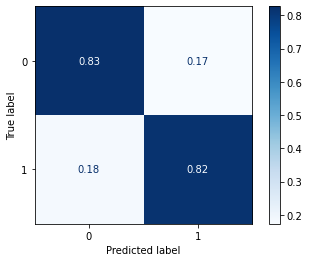

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2012 to 2015, shows a good performance of the model, with 82% of accuracy.

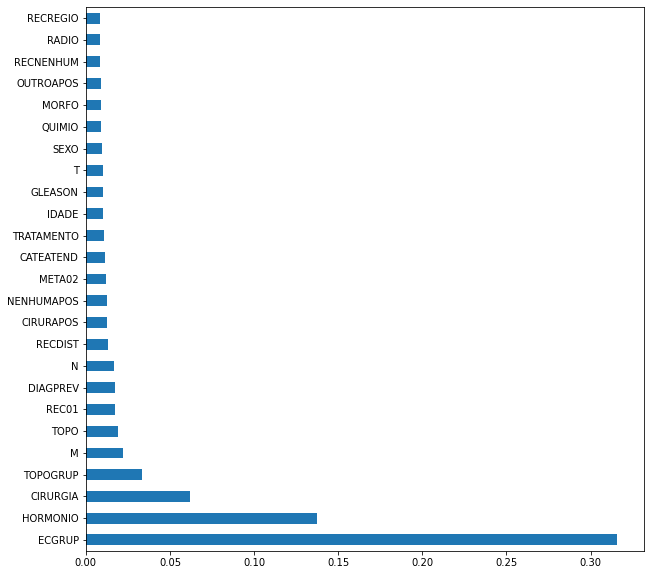

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, with a good advantage, `HORMONIO`, `CIRURGIA` and `TOPOGRUP`.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=15, random_state=seed, 
                                 scale_pos_weight=1.3)
xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.3, seed=None,
              silent=None, subsample=1, verbosity=1)

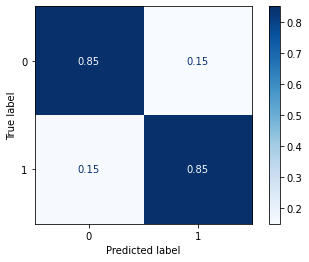

In [ ]:
plot_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with the SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.



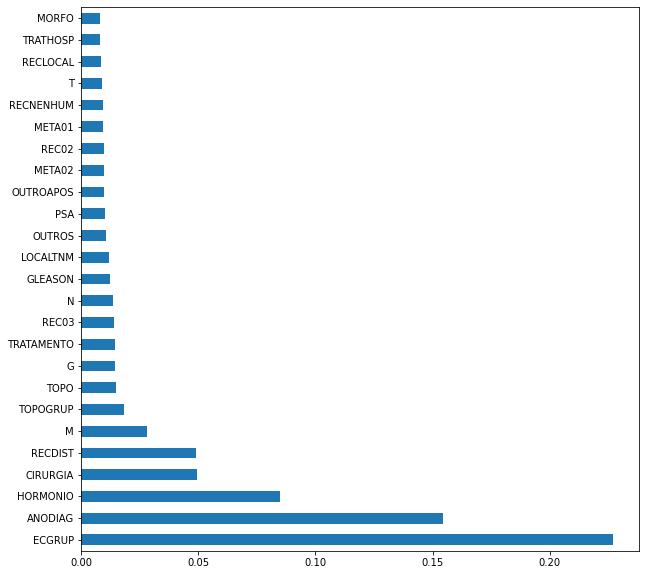

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `HORMONIO` and `CIRURGIA`.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=15, random_state=seed,
                                   scale_pos_weight=0.27)
xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.27, seed=None,
              silent=None, subsample=1, verbosity=1)

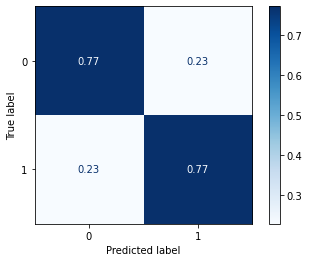

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 77% of accuracy.

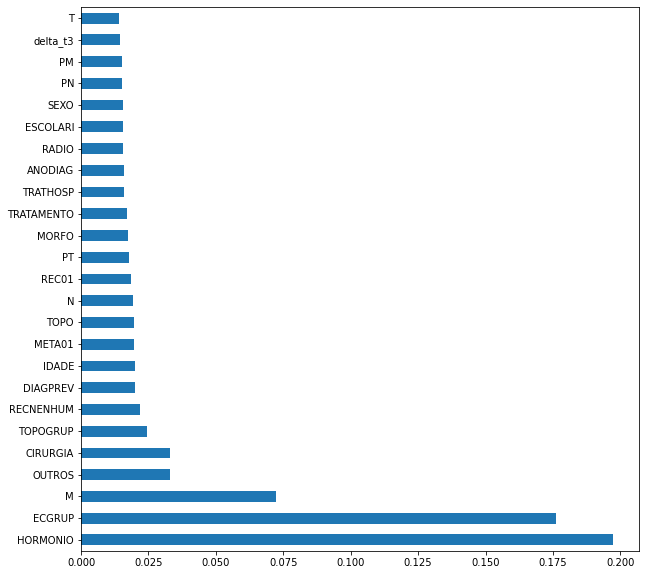

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> The two most important features in the model were `HORMONIO`, `ECGRUP`, `M` and `OUTROS`.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.27,
                                   random_state=seed)
xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.27, seed=None,
              silent=None, subsample=1, verbosity=1)

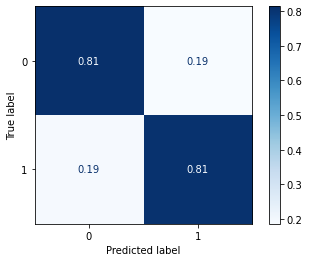

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a very good performance of the model with 81% of accuracy.

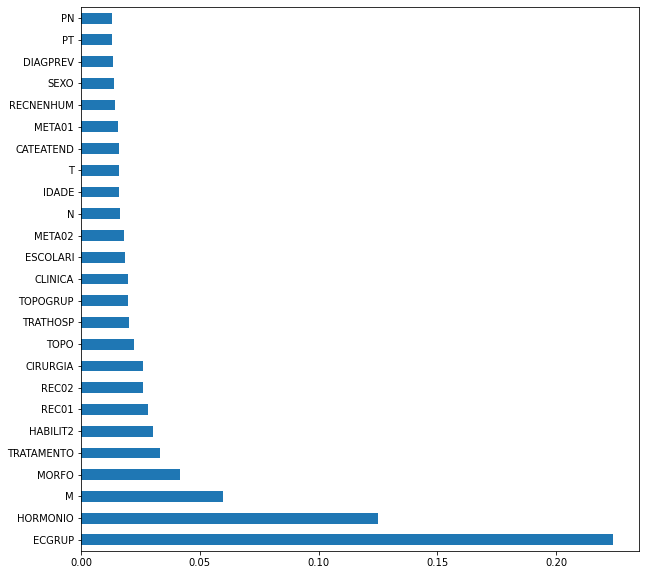

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> The two most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `MORFO`.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.25,
                                   random_state=seed)
xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25, seed=None,
              silent=None, subsample=1, verbosity=1)

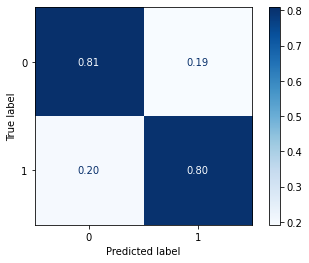

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, presented 80% of accuracy.

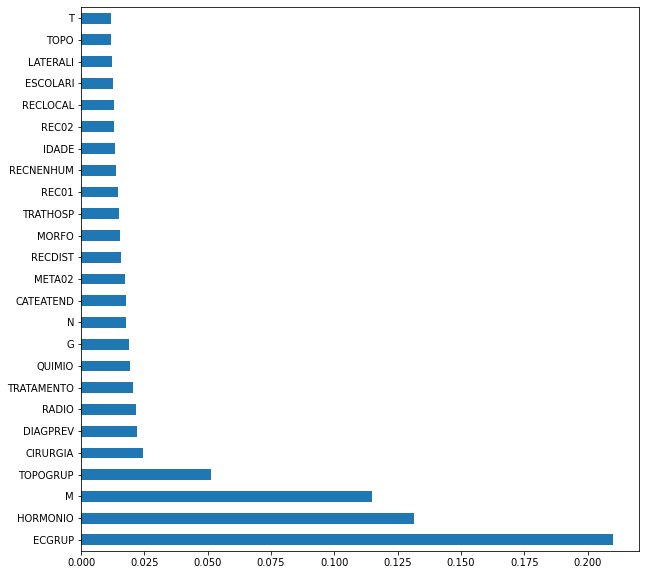

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `M` and `TOPOGRUP`.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=0.2,
                                   random_state=seed)
xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.2, seed=None,
              silent=None, subsample=1, verbosity=1)

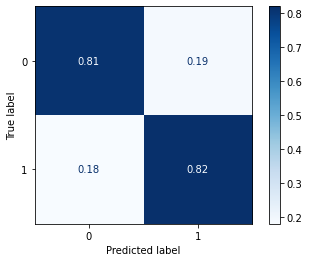

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, presented 81% of accuracy.

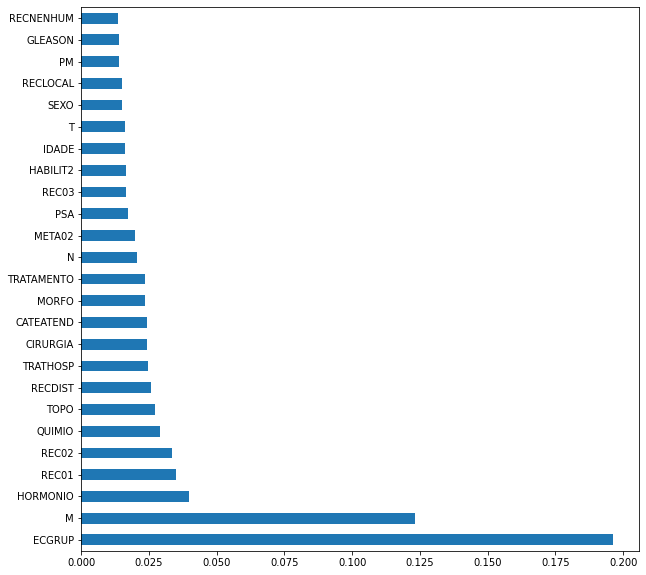

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `HORMONIO` and `REC01`.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=15, scale_pos_weight=1,
                                  random_state=seed)
xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

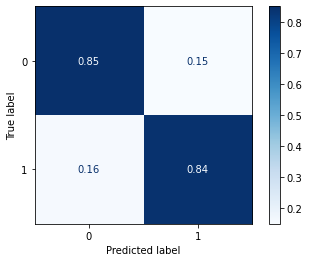

In [ ]:
plot_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20,
                      cmap='Blues', normalize='true', values_format='.2f')
plt.show()

> The confusion matrix obtained for the XGBoost, with other states from 2016 to 2020, shows a good performance, with 84% of accuracy.

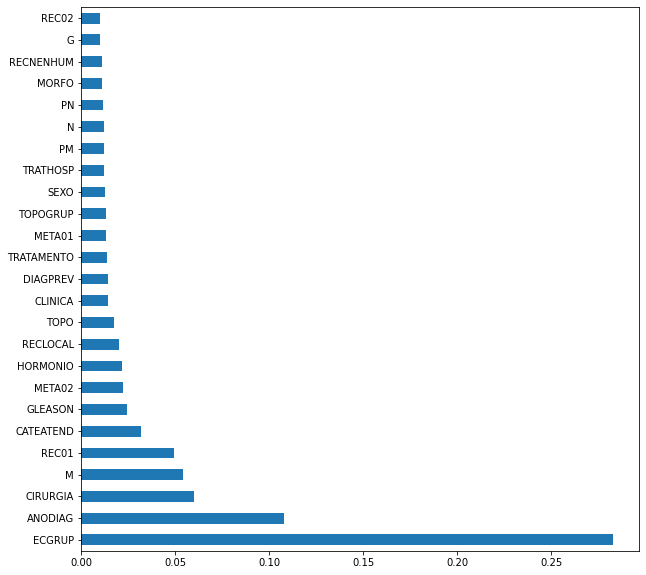

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, with a good advantage, `ANODIAG`, `CIRURGIA` and `M`.

## **Testing models with data from other years**

### **Random Forest SP for years 2000 to 2003**

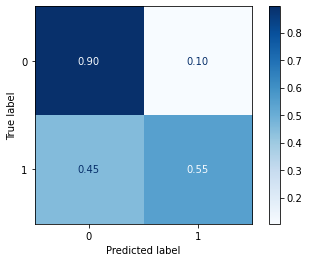

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

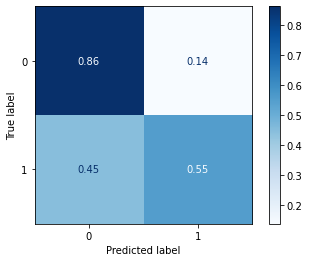

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

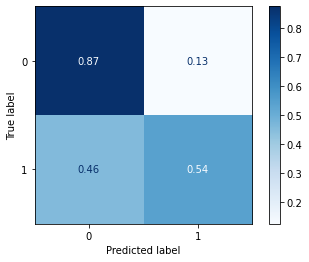

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

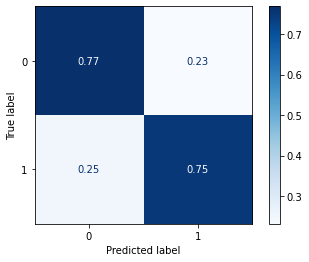

In [ ]:
plot_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2000 to 2003**

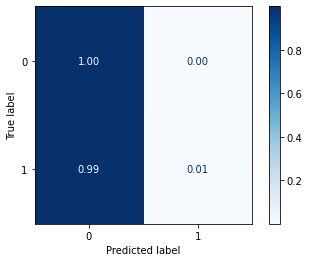

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

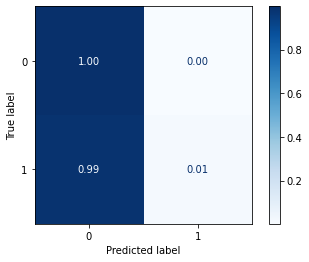

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

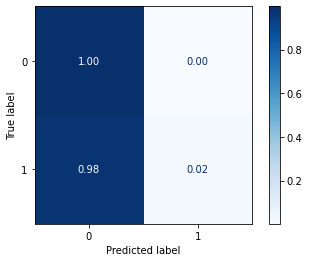

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

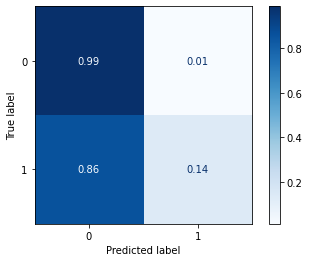

In [ ]:
plot_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2004 to 2007**

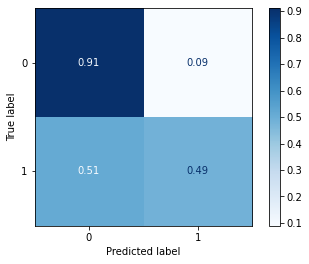

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

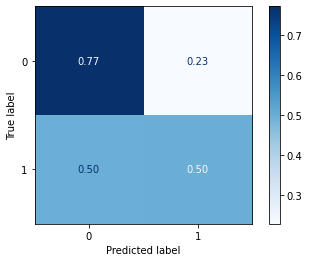

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

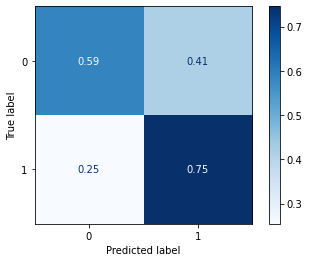

In [ ]:
plot_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2004 to 2007**

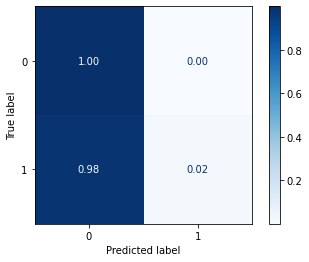

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

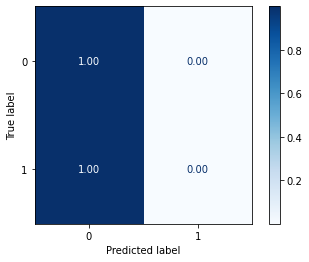

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

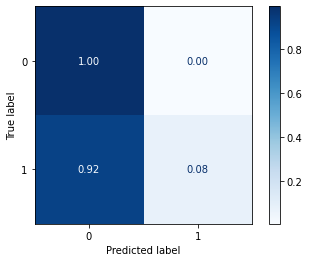

In [ ]:
plot_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2008 to 2011**

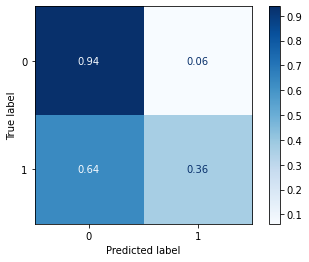

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

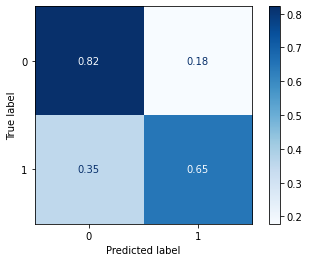

In [ ]:
plot_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2008 to 2011**

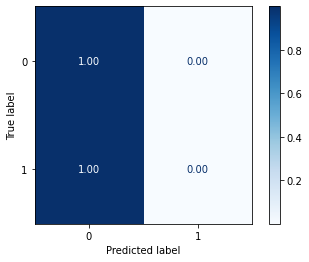

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

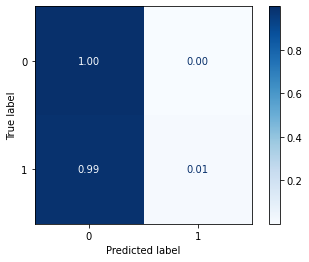

In [ ]:
plot_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest SP for years 2012 to 2015**

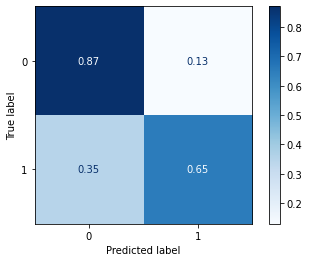

In [ ]:
plot_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost SP for years 2012 to 2015**

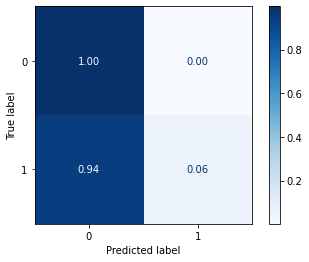

In [ ]:
plot_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2000 to 2003**

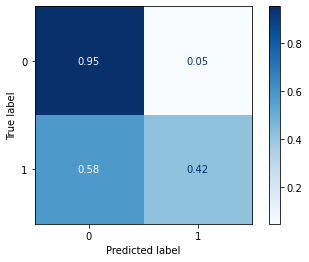

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

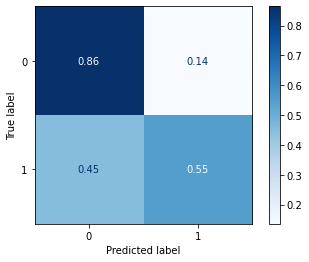

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

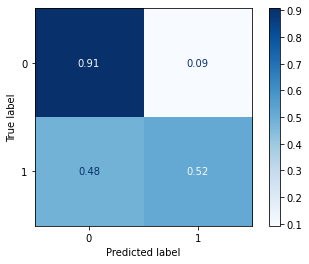

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

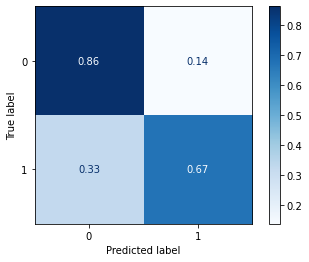

In [ ]:
plot_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2000 to 2003**

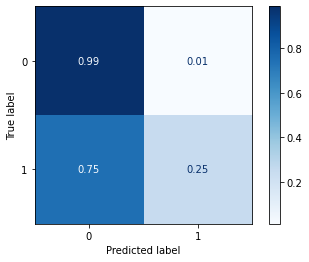

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

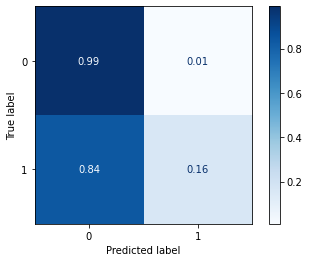

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

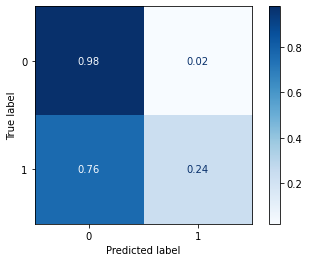

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

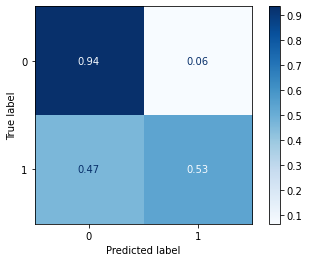

In [ ]:
plot_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2004 to 2007**

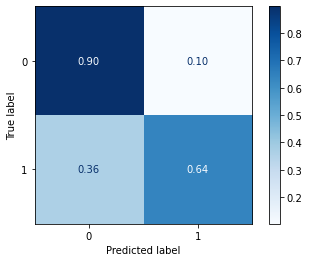

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

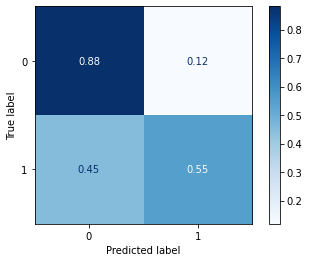

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

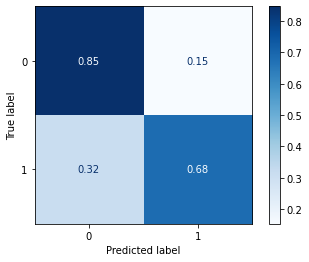

In [ ]:
plot_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2004 to 2007**

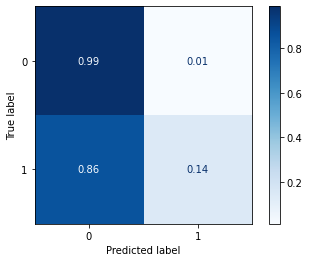

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

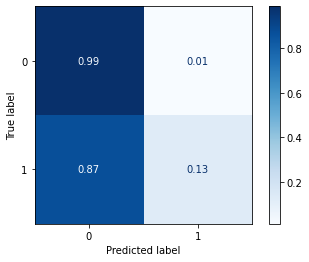

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

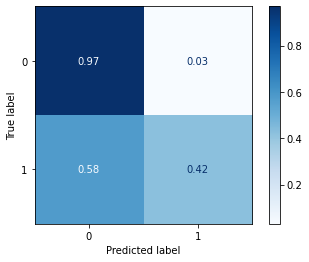

In [ ]:
plot_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2008 to 2011**

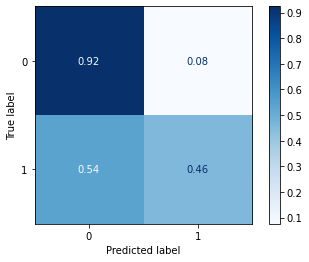

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

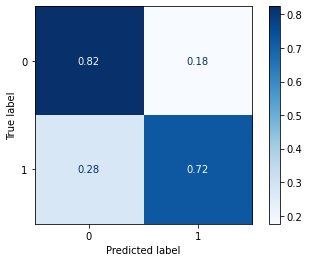

In [ ]:
plot_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2008 to 2011**

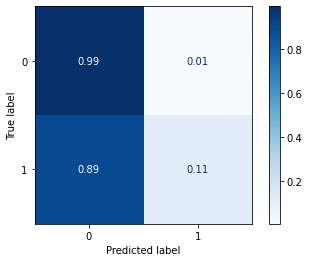

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

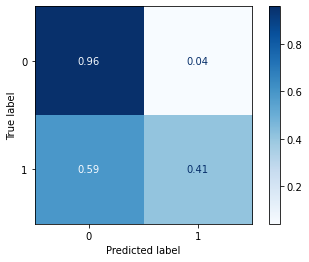

In [ ]:
plot_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **Random Forest Other states for years 2012 to 2015**

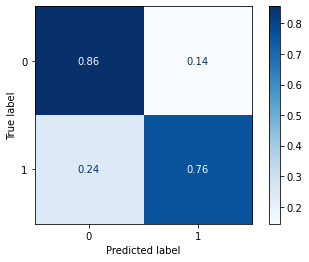

In [ ]:
plot_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()

### **XGBoost Other states for years 2012 to 2015**

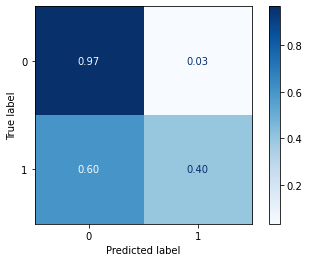

In [ ]:
plot_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20, cmap='Blues',
                      normalize='true', values_format='.2f')
plt.show()